## EDA on SPAM Messages

In [2]:
import pandas as pd

In [3]:
file_path: str = "data/SMSSpamCollection"

df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'text'])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


TODO Sanity checks: Read the readme file in the data folder. How could we check if the data is read correctly?

In [4]:
# Zeige einige zufällige Zeilen zur Überprüfung der Struktur
df.sample(5)

# Zeige Datentypen & Struktur
df.info()

# Zeige eindeutige Label-Werte (sollten nur "ham" und "spam" sein)
df['label'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


array(['ham', 'spam'], dtype=object)

In [5]:
len(df) # number of rows

5572

TODO Check if values are null? (If labels or text are null, remove the rows)

In [6]:
# Prüfen auf fehlende Werte
print(df.isnull().sum())

# Falls vorhanden: Entfernen
df = df.dropna()


label    0
text     0
dtype: int64


TODO describe the data statistically using pandas
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

In [7]:
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()


count    5572.000000
mean       80.490309
std        59.944527
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: text_length, dtype: float64

In [8]:
df = df.drop_duplicates(subset=['text'])

### Text Analysis

In [9]:
def preprocess_text(text: str):
    return text.lower().split()

In [10]:
preprocessed_column: str = "preprocessed_text"
text_column : str = 'text'

# tokenize and normalize text
df[preprocessed_column] = df[text_column].apply(preprocess_text)

Text(0, 0.5, 'Anzahl Nachrichten')

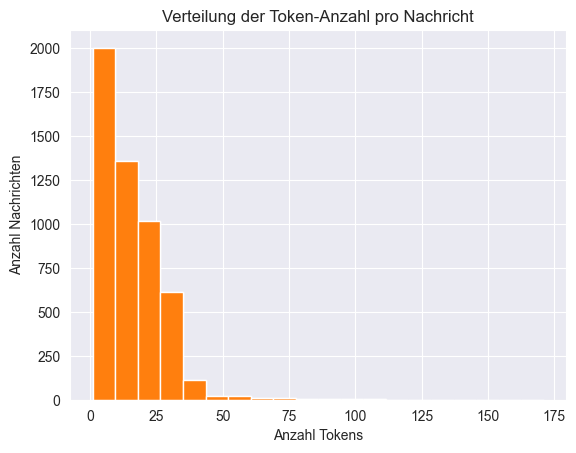

In [11]:
# TODO: add diagram title, titles for X/Y
df[preprocessed_column].apply(len).plot(kind="hist", bins=20)
ax = df[preprocessed_column].apply(len).plot.hist(bins=20, title="Verteilung der Token-Anzahl pro Nachricht")
ax.set_xlabel("Anzahl Tokens")
ax.set_ylabel("Anzahl Nachrichten")

In [12]:
# TODO count the least frequent terms
df.explode(preprocessed_column)[preprocessed_column].value_counts().tail(20)
df.explode(preprocessed_column)[preprocessed_column].value_counts().head(20)

preprocessed_text
i       2102
to      2065
you     1836
a       1295
the     1235
and      920
u        897
in       789
is       773
my       680
for      659
your     619
me       585
of       553
have     535
on       477
call     470
are      459
that     455
it       441
Name: count, dtype: int64

In [13]:
# TODO many of the top frequent words are stopwords. Remove them using NLTK
# use the corpus module for that (https://www.nltk.org/howto/corpus.html#word-lists-and-lexicons)predictionprepre
#import nltk
#nltk.download('stopwords')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mirav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

In [15]:
def preprocess_text(text: str) -> list[str]:
    tokens = text.lower().split()
    return [word for word in tokens if word not in stop_words]

In [16]:
df[preprocessed_column] = df[text_column].apply(preprocess_text)

In [17]:
df[[text_column, preprocessed_column]].head()

,text,preprocessed_text
0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point,, crazy.., available, bugis..."
1,Ok lar... Joking wif u oni...,"[ok, lar..., joking, wif, u, oni...]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor..., u, c, already, sa..."
4,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf,, lives, around, though]"


### Correlations

In [18]:
# take the 30 most frequent words, and correlate to labels
df_words_exploded = df.explode(preprocessed_column)
top_50_words: list[str] = df_words_exploded[preprocessed_column].value_counts()[:20].index.tolist()
top_50_words

['u',
 'call',
 '2',
 'get',
 'ur',
 'go',
 '&lt;#&gt;',
 '4',
 'got',
 'like',
 'know',
 'come',
 'free',
 'good',
 '?',
 'want',
 '.',
 'send',
 '...',
 'time']

In [19]:
columns = ['is_spam']
df['is_spam'] = df['label']=='spam'

for token in top_50_words:
    token_column = f"{token}_count"
    df[token_column] = df[preprocessed_column].apply(lambda token_list: token_list.count(token))
    columns.append(token_column)

In [20]:
df[columns].corr()

,is_spam,u_count,call_count,2_count,get_count,ur_count,go_count,&lt;#&gt;_count,4_count,got_count,...,know_count,come_count,free_count,good_count,?_count,want_count,._count,send_count,..._count,time_count
is_spam,1.000000,-0.019579,0.446223,0.169943,0.051020,0.154416,-0.015771,-0.051997,0.119191,-0.061891,...,-0.032863,-0.066504,0.338359,-0.033800,-0.033442,0.016840,-0.012904,0.115150,-0.041316,-0.016687
u_count,-0.019579,1.000000,0.010178,0.217855,0.023539,0.127366,0.036218,0.008280,0.093785,0.020017,...,0.036360,0.004690,-0.006435,0.009387,-0.029473,-0.011602,0.056931,0.022756,-0.032963,0.054168
call_count,0.446223,0.010178,1.000000,0.020873,-0.018830,-0.018851,-0.027271,-0.024368,-0.003047,-0.028177,...,-0.015701,-0.031485,0.183009,-0.031145,-0.026858,0.012432,-0.001748,-0.033638,-0.028787,0.001543
2_count,0.169943,0.217855,0.020873,1.000000,0.010538,0.144348,0.061750,-0.008065,0.195006,0.046540,...,-0.026505,-0.007970,0.070358,-0.015685,-0.020498,0.049722,-0.004542,0.014947,-0.017652,0.021690
get_count,0.051020,0.023539,-0.018830,0.010538,1.000000,0.037125,0.020159,0.023485,0.045924,-0.001926,...,0.015686,0.007197,0.099989,0.001353,0.010335,0.022199,-0.007844,0.044074,-0.002478,0.032140
ur_count,0.154416,0.127366,-0.018851,0.144348,0.037125,1.000000,0.003344,-0.008481,0.130472,0.011937,...,-0.009627,0.007548,0.079416,0.018576,-0.013003,-0.010206,0.024554,0.083437,-0.021361,0.000451
go_count,-0.015771,0.036218,-0.027271,0.061750,0.020159,0.003344,1.000000,-0.015130,0.131446,0.060499,...,0.013855,0.007530,0.022055,-0.017557,0.039121,0.070150,-0.000669,-0.000107,0.033798,0.009430
&lt;#&gt;_count,-0.051997,0.008280,-0.024368,-0.008065,0.023485,-0.008481,-0.015130,1.000000,-0.000965,0.014544,...,0.022131,-0.007822,0.000292,0.098680,-0.001693,-0.002109,0.604619,0.021089,-0.015630,-0.002552
4_count,0.119191,0.093785,-0.003047,0.195006,0.045924,0.130472,0.131446,-0.000965,1.000000,0.027332,...,-0.022894,-0.021468,0.076441,-0.023461,-0.014321,-0.022680,0.003966,0.008338,-0.016582,0.018193
got_count,-0.061891,0.020017,-0.028177,0.046540,-0.001926,0.011937,0.060499,0.014544,0.027332,1.000000,...,-0.001517,0.026000,-0.015390,-0.009943,0.008368,0.000703,-0.002609,-0.015784,-0.016840,0.004672


<Axes: >

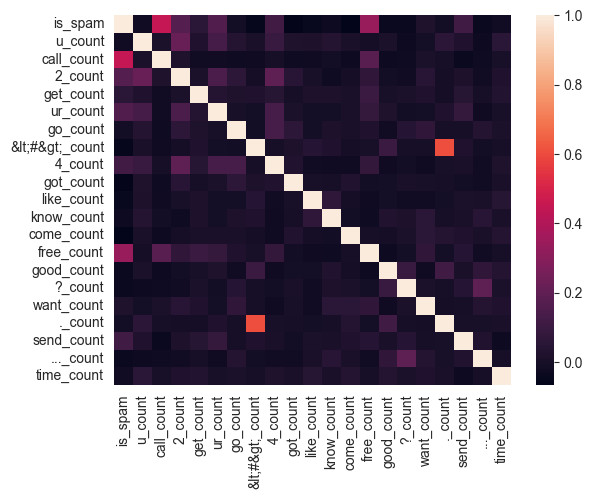

In [21]:
import seaborn

seaborn.heatmap(df[columns].corr())

In [22]:
# save data to csv
df.to_csv('data/prepared_sms_data.csv', index=False)